<p><strong>Objective:</strong> To build a model that can classify the total number of goals scored in a soccer match, given publicly available data</p>
<p><strong>Performance criteria:</strong> F1 score</p>

In [1]:
path = r"C:\Machine_learning_datafiles\footballPrediction"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
os.chdir(path)

In [4]:
os.getcwd()

'C:\\Machine_learning_datafiles\\footballPrediction'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle

In [50]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import lightgbm as lgb
import catboost as cat
from sklearn.metrics import f1_score, plot_roc_curve, plot_confusion_matrix, classification_report

In [7]:
%matplotlib inline
pd.set_option('display.max_columns', None)

In [8]:
!ls *'_cleaned.pkl'

test_cleaned.pkl
train_cleaned.pkl
valid_cleaned.pkl


In [9]:
train = pd.read_pickle('train_cleaned.pkl', compression='gzip')
valid = pd.read_pickle('valid_cleaned.pkl', compression='gzip')
test = pd.read_pickle('test_cleaned.pkl', compression='gzip')

In [10]:
train.head(4)

,teams_home_team_id,teams_away_team_id,fixture_venue,league_id,league_name,league_country,league_season,league_round,home_team_country,away_team_country,match_winner,under_over,goals_home,goals_away,winning_percent_home,winning_percent_draws,winning_percent_away,comparison_forme_home,comparison_forme_away,comparison_att_home,comparison_att_away,comparison_def_home,comparison_def_away,comparison_fish_law_home,comparison_fish_law_away,comparison_h2h_home,comparison_h2h_away,comparison_goals_h2h_home,comparison_goals_h2h_away,teams_home_last_5_matches_forme,teams_home_last_5_matches_att,teams_home_last_5_matches_def,teams_away_last_5_matches_forme,teams_away_last_5_matches_att,teams_away_last_5_matches_def,teams_home_last_5_matches_goals,teams_home_last_5_matches_goals_avg,teams_home_last_5_matches_goals_against,teams_home_last_5_matches_goals_against_avg,teams_home_all_last_matches_matchs_matchsPlayed_home,teams_home_all_last_matches_matchs_matchsPlayed_away,teams_home_all_last_matches_matchs_wins_home,teams_home_all_last_matches_matchs_wins_away,teams_home_all_last_matches_matchs_draws_home,teams_home_all_last_matches_matchs_draws_away,teams_home_all_last_matches_matchs_loses_home,teams_home_all_last_matches_matchs_loses_away,teams_home_all_last_matches_goals_goalsFor_home,teams_home_all_last_matches_goals_goalsFor_away,teams_home_all_last_matches_goals_goalsAgainst_home,teams_home_all_last_matches_goals_goalsAgainst_away,teams_home_all_last_matches_goalsAvg_goalsFor_home,teams_home_all_last_matches_goalsAvg_goalsFor_away,teams_home_all_last_matches_goalsAvg_goalsAgainst_home,teams_home_all_last_matches_goalsAvg_goalsAgainst_away,teams_home_last_h2h_played_home,teams_home_last_h2h_played_away,teams_home_last_h2h_wins_home,teams_home_last_h2h_wins_away,teams_home_last_h2h_draws_home,teams_home_last_h2h_draws_away,teams_home_last_h2h_loses_home,teams_home_last_h2h_loses_away,teams_away_last_5_matches_goals,teams_away_last_5_matches_goals_avg,teams_away_last_5_matches_goals_against,teams_away_last_5_matches_goals_against_avg,teams_away_all_last_matches_matchs_matchsPlayed_home,teams_away_all_last_matches_matchs_matchsPlayed_away,teams_away_all_last_matches_matchs_wins_home,teams_away_all_last_matches_matchs_wins_away,teams_away_all_last_matches_matchs_draws_home,teams_away_all_last_matches_matchs_draws_away,teams_away_all_last_matches_matchs_loses_home,teams_away_all_last_matches_matchs_loses_away,teams_away_all_last_matches_goals_goalsFor_home,teams_away_all_last_matches_goals_goalsFor_away,teams_away_all_last_matches_goals_goalsAgainst_home,teams_away_all_last_matches_goals_goalsAgainst_away,teams_away_all_last_matches_goalsAvg_goalsFor_home,teams_away_all_last_matches_goalsAvg_goalsFor_away,teams_away_all_last_matches_goalsAvg_goalsAgainst_home,teams_away_all_last_matches_goalsAvg_goalsAgainst_away,teams_away_last_h2h_played_home,teams_away_last_h2h_played_away,teams_away_last_h2h_wins_home,teams_away_last_h2h_wins_away,teams_away_last_h2h_draws_home,teams_away_last_h2h_draws_away,teams_away_last_h2h_loses_home,teams_away_last_h2h_loses_away,outcome,fixture_year,fixture_week,fixture_day,fixture_month,fixture_weekday,venue_status,weather_season
0,3396,3400,Tsirion Athltiko Kentro,2658,1. Division,Cyprus,2020,Regular Season - 9,Cyprus,Cyprus,1 N,NaN,-2.5,-1.5,45,45,10,56,44,83,17,27,73,61,39,100,0,73,27,60,100.0,11.0,47,22.0,67.0,10,2.0,8,1.6,3,5,3,2,0,0,0,3,9,5,3,8,3.0,1.0,1.0,1.6,2,2,2,2,0,0,0,0,2,0.4,3,0.6,4,4,0,3,1,0,3,1,0,5,9,3,0.0,1.3,2.3,0.8,2,2,0,0,0,0,2,2,Over,2020,44,6,10,5,Home,fall
1,2788,2777,UMT Stadium Ubon Ratchathani,390,Thai Premier League,Thailand,2017,Regular Season - 34,Thailand,Thailand,1 N,1.5,-2.5,-2.5,45,45,10,100,0,50,50,73,27,0,0,50,50,67,33,47,50.0,50.0,0,50.0,0.0,8,1.6,8,1.6,16,17,6,5,7,4,3,8,29,24,24,29,1.8,1.4,1.5,1.7,2,3,1,1,0,0,1,2,8,1.6,22,4.4,17,16,4,2,5,0,8,14,26,16,41,47,1.5,1.0,2.4,2.9,3,2,2,1,0,0,1,1,Over,2017,46,6,11,5,Neutral,fall
2,8268,8265,LeithArena,1087,Landesliga - Burgenland,Austria

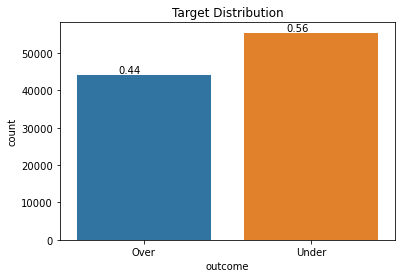

In [11]:
ax = sns.countplot(train.outcome)
for i in ax.patches:
    val = round(i.get_height()/train.shape[0], 2)
    plt.text(i.get_x()+0.25, i.get_height() + 500, str(val))
plt.title('Target Distribution');

<b>The outcome distribution isn't highly imbalanced</b>

In [12]:
for data_df in [train, test, valid]:
    # league Regular season, Groupstage etc
    data_df['league_type'] = data_df.league_round.str.split(' -').str[0].str.strip()
    
    # checks if match is a domestic match or not
    data_df['match_type'] = ((train.home_team_country == train.league_country) & \
    (train.away_team_country == train.league_country)) * 1

In [13]:
missing = pd.DataFrame(train.isna().sum()/len(train) * 100)
missing.columns = ['Percentage']
missing[missing.Percentage > 0].sort_values(by='Percentage', ascending=False).index.values

array(['under_over', 'goals_home', 'goals_away', 'fixture_venue',
       'match_winner', 'away_team_country', 'home_team_country',
       'teams_home_last_5_matches_att', 'teams_home_last_5_matches_def',
       'teams_away_last_5_matches_def', 'teams_away_last_5_matches_att'],
      dtype=object)

Most of Under_over are missing. There's a little likelihood if it will be an important feature, since 71% are missing.

<b>Filling Missing values</b>

In [14]:
def fillMissing(train, test, valid):
    # filling categorical features
    cat_col = train.select_dtypes('object').columns.drop('outcome')
    train[cat_col] = train[cat_col].fillna('Unk')
    test[cat_col] = test[cat_col].fillna('Unk')
    valid[cat_col] = test[cat_col].fillna('Unk')
    
    le = LabelEncoder()
    for col in cat_col:
        train[col] = le.fit_transform(train[col])
        valid[col] = valid[col].apply(lambda x: 'unk' if x not in le.classes_ else x)
        test[col] = test[col].apply(lambda x: 'unk' if x not in le.classes_ else x)
        
        le_classes = le.classes_.tolist()
        le_classes.insert(len(le_classes), 'unk')
        le.classes_ = le_classes
        
        valid[col] = le.transform(valid[col])
        test[col] = le.transform(test[col])
    
    return train, valid, test

In [15]:
%%time
train, valid, test = fillMissing(train, test, valid)

Wall time: 44.9 s


<strong>I will replace numerical features with their median values. I would have used KNNImputer but the computational requirements is too much.</strong>

In [16]:
missing_cols = ['goals_away', 'goals_home', 'teams_home_last_5_matches_att', 'teams_home_last_5_matches_def',
                'teams_away_last_5_matches_att', 'teams_away_last_5_matches_def']
median = train[missing_cols].median()

In [17]:
train[missing_cols] = train[missing_cols].fillna(median)
valid[missing_cols] = valid[missing_cols].fillna(median)
test[missing_cols] = test[missing_cols].fillna(median)

In [18]:
train.outcome = train.outcome.map({'Under' : 1, 'Over' : 0})
valid.outcome = valid.outcome.map({'Under' : 1, 'Over' : 0})

In [19]:
for col in ['fixture_year', 'fixture_week', 'fixture_day']:
    train[col] = train[col].astype('int32')
    valid[col] = valid[col].astype('int32')
    test[col] = test[col].astype('int32')

In [20]:
xtrain, ytrain = train.drop('outcome', axis=1), train.outcome
xvalid, yvalid = valid.drop('outcome', axis=1), valid.outcome

In [21]:
seed = 42

In [22]:
lgb_params = {
    'metrics' : 'auc',
    'objective' : 'binary',
    'min_child_samples' : 5,
    'max_depth' : 8,
    'num_leaves' : 64,
    'min_child_weight' : 5,
    'importance_type' : 'gain',
    'subsample' : 0.8,
    'colsample_bytree' : 0.3,
    'boosting_type' : 'gbdt',
    'learning_rate' : 0.01,
    'reg_lambda' : 0.8,
    'random_state' : seed,
    'n_estimators' : 800,
}

In [34]:
cat_params = {
    'eval_metric' : 'AUC',
    'bootstrap_type' : 'Bernoulli',
    'n_estimators' : 800,
    'od_type' : 'Iter',
    'max_depth' : 7,
    'l2_leaf_reg' : 0.8,
    'learning_rate' : 0.01,
    'loss_function' : 'Logloss',
    'random_state' : seed,
    'subsample' : 0.7,
    'rsm' : 0.3,
    'silent' : True
}

In [24]:
def buildModel(classifier):
    classifier.fit(xtrain, ytrain, early_stopping_rounds=100,
                   eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                   verbose=False)
    f1_tr = metrics(classifier, xtrain, ytrain)
    f1_val = metrics(classifier, xvalid, yvalid)
    print(f'Train F1: {f1_tr.round(4)}, Valid F1: {f1_val.round(4)}')
    return classifier

In [25]:
def metrics(clf, x, y):
    f1 = f1_score(y, clf.predict(x), average='weighted')
    return f1

In [26]:
def plot_figures(clf):
    fig, ax= plt.subplots(1,2,figsize=(12,4))
    plot_confusion_matrix(clf, xvalid, yvalid, ax=ax[0])
    plot_roc_curve(clf, xvalid, yvalid, ax=ax[1])

In [27]:
def featureImportances(clf):
    pd.Series(clf.feature_importances_, index=xvalid.columns
             ).sort_values()[-15:].plot.barh()

In [35]:
catm = cat.CatBoostClassifier(**cat_params)
lgbm = lgb.LGBMClassifier(**lgb_params)

In [29]:
buildModel(lgbm);

Train F1: 0.6714, Valid F1: 0.6373


In [36]:
buildModel(catm);

Train F1: 0.6449, Valid F1: 0.6277


In [37]:
lgbm.best_iteration_,  catm.best_iteration_

(537, 718)

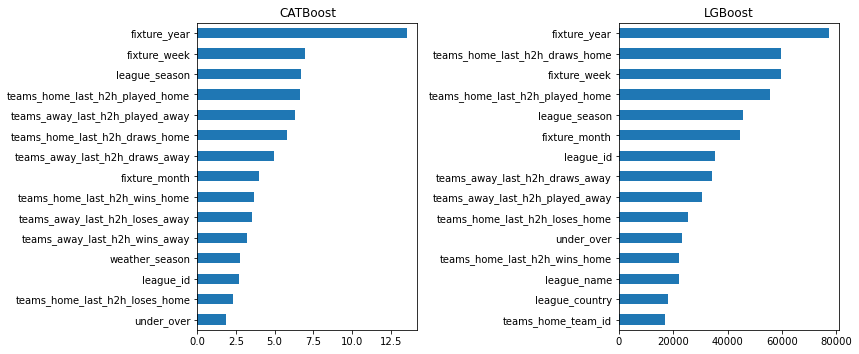

In [38]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
featureImportances(catm)
plt.title('CATBoost')
plt.subplot(1,2,2)
featureImportances(lgbm)
plt.title('LGBoost')
plt.tight_layout(pad=1.);

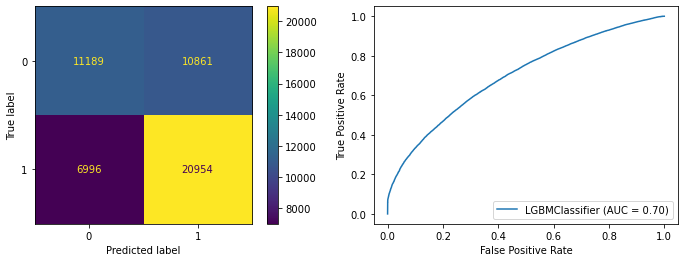

In [39]:
plot_figures(lgbm)

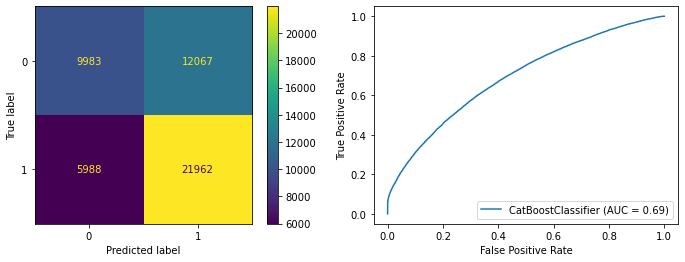

In [40]:
plot_figures(catm)

### Validation Predictions

In [41]:
cat_predv = catm.predict_proba(xvalid)[:, 1]
lgb_predv = lgbm.predict_proba(xvalid)[:, 1]

In [42]:
blend = np.round((lgb_predv * 0.6 + cat_predv * 0.4)).astype('int32')

In [43]:
f1_score(yvalid, blend, average='weighted')

0.6345499498641975

In [49]:
# without weighted average
f1_score(yvalid, blend)

0.7060274648466408

In [52]:
print(classification_report(yvalid, blend, target_names=['Over', 'Under']))

              precision    recall  f1-score   support

        Over       0.62      0.48      0.54     22050
       Under       0.65      0.77      0.71     27950

    accuracy                           0.64     50000
   macro avg       0.64      0.63      0.62     50000
weighted avg       0.64      0.64      0.63     50000



<b>Test Predictions</b>

In [44]:
preds = np.round((0.6*lgbm.predict(test) + 0.4*catm.predict(test))).astype('int32')

In [45]:
pred_250 = preds[:250]
pred_500 = preds[250:]

In [46]:
pred_250

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1])

In [47]:
pred_500

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1])

In [48]:
pickle.dump(lgbm, open('lgb3.pkl', 'wb'))
pickle.dump(catm, open('cat3.pkl', 'wb'))